In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
with open('../data/Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
len(texts)

29875

In [4]:
from transformers import BertTokenizer, TFRobertaForSequenceClassification

In [5]:
tokenizer = BertTokenizer.from_pretrained("klue/roberta-small")

C:\Users\yong\anaconda3\envs\textmining_cpu\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yong\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
model = TFRobertaForSequenceClassification.from_pretrained("klue/roberta-small", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [7]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [9]:
len(X_train)

23900

In [10]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [11]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_roberta_kr"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [13]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 508s 3s/step - loss: 0.3758 - accuracy: 0.8341 - val_loss: 0.3494 - val_accuracy: 0.8577
Epoch 2/10
169/169 [==============================] - 497s 3s/step - loss: 0.2478 - accuracy: 0.9009 - val_loss: 0.2811 - val_accuracy: 0.8866
Epoch 3/10
169/169 [==============================] - 488s 3s/step - loss: 0.1977 - accuracy: 0.9241 - val_loss: 0.2872 - val_accuracy: 0.8929
Epoch 4/10
169/169 [==============================] - 490s 3s/step - loss: 0.1608 - accuracy: 0.9391 - val_loss: 0.3190 - val_accuracy: 0.8904
Epoch 5/10
169/169 [==============================] - 488s 3s/step - loss: 0.1171 - accuracy: 0.9579 - val_loss: 0.3811 - val_accuracy: 0.8795
Epoch 5: early stopping


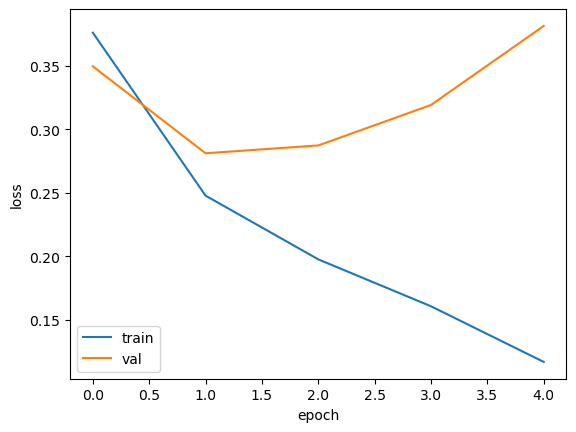

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

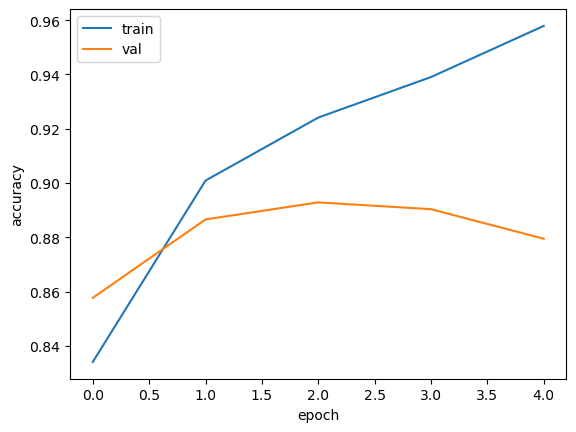

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [16]:
model.load_weights(checkpoint_filepath)
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

187/187 [==============================] - 44s 229ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2867
           1       0.90      0.90      0.90      3108

    accuracy                           0.90      5975
   macro avg       0.90      0.90      0.90      5975
weighted avg       0.90      0.90      0.90      5975

